In [27]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import date


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import itertools

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import pandas_profiling
from pandas_profiling import ProfileReport

In [28]:
rsndom_seed = 42
data_directory = '/kaggle/input/sf-dst-scoring/'
!pip freeze > requirements.txt

In [29]:
#DATA_DIR = '../input/sf-dst-scoring/'
DATA_DIR = ''
data_train = pd.read_csv(DATA_DIR+'train.csv')
data_test = pd.read_csv(DATA_DIR+'test.csv')
sample_submission = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [30]:
# Объединим в общий датасет
data_train['sample'] = 1 #трейн
data_test['sample'] = 0 # тест
train = data_train.append(data_test, sort=False).reset_index(drop=True)

EDA Посмотрим на переменные, которые содержит датасет:

client_id - идентификатор клиента

app_date - дата подачи заявки

education - уровень образования ('SCH', 'GRD', 'UGR', 'PGR', 'ACD')

sex - пол заёмщика ('F' - женский, 'M' - мужской)

age - возраст заёмщика

car - флаг наличия автомобиля ('Y' - да, 'N' - нет)

car_type - флаг автомобиля-иномарки ('Y' - да, 'N' - нет)

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия «хорошей» работы ('1' - да, '0' - нет)

score_bki - скоринговый балл по данным из БКИ

bki_request_cnt - количество запросов в БКИ

region_rating - рейтинг региона

home_address - категоризатор домашнего адреса (1, 2, 3)

work_address - категоризатор рабочего адреса (1, 2, 3)

income - доход заёмщика

sna - связь заемщика с клиентами банка

foreign_passport - наличие загранпаспорта ('Y' - да, 'N' - нет)

first_time - давность наличия информации о заемщике

default - наличие дефолта ('1' - да, '0' - нет)

Итого у нас: 110148 наблюдений. 18 признаков + целевая переменная. Пропущенные значения только в education самое популярное - SСH.

числовые признаки: client_id, age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income

бинарные признаки: sex, car, car_type, foreign_passport, good_work, default

категориальные признаки: education, home_address, work_address, first_time, sna

плюс дата подачи app_date и бинарный целевой признак

In [ ]:
#profile = ProfileReport(train)
#profile

In [ ]:
#profile.to_file("EDA_report.html")

Низкая корреляция признаков по Пирсону, можно использовать в модели

Подготовка признаков

In [31]:
#Удаляем столбец client_id
train = train.drop(['client_id'], axis=1)

In [32]:
# Преобразуем текущую дату
train['app_date']= pd.to_datetime(train['app_date'])

In [33]:
#Заменим пропущенное значение самым популярным - SСH
train['education'].fillna('SCH', inplace=True)

In [34]:
train['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [35]:
le = LabelEncoder()
train['education'] = le.fit_transform(train['education'])

In [36]:
# Разобьем категориальные,бинарные и числовые признаки в отдельные колонки
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time']  # категориальные
bin_cols = ['sex', 'car', 'car_type',
            'foreign_passport', 'good_work']  # бинарные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'region_rating', 'score_bki']  # числовые
time_col = ['app_date'] #временные

In [37]:
#Логарифмируем
train['decline_app_cnt'] = np.log(train['decline_app_cnt']+1)
train['income'] = np.log(train['income']+1)
train['age'] = np.log(train['age']+1)

кодирование признаков

In [38]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [39]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    
# убедимся в преобразовании    
train.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,2014-02-01,3,1,4.143135,1,1,0.000000,0,-2.008753,1,50,1,2,9.798183,4,1,0,0.0,1
1,2014-03-12,3,0,4.094345,0,0,0.000000,0,-1.532276,3,50,2,3,9.852247,4,1,0,0.0,1
2,2014-02-01,3,1,3.258097,1,0,1.098612,0,-1.408142,1,80,1,2,10.308986,1,4,1,0.0,1
3,2014-01-23,3,0,3.988984,0,0,0.000000,0,-2.057471,2,50,2,3,9.210440,1,3,0,0.0,1
4,2014-04-18,1,1,3.891820,0,0,0.000000,1,-1.244723,1,60,2,3,10.308986,1,4,1,0.0,1


In [40]:
train_df = train[train['sample']==1]

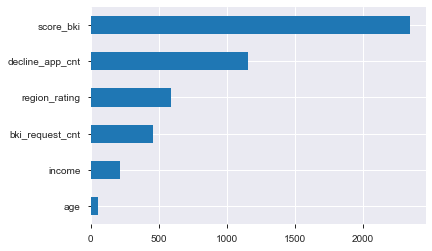

In [41]:
imp_num = Series(f_classif(train_df[num_cols], 
                           train_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

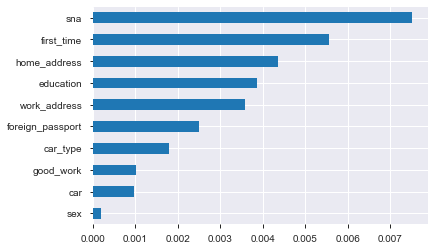

In [42]:
imp_cat = Series(mutual_info_classif(train_df[bin_cols + cat_cols], train_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [43]:
train = pd.get_dummies(train, prefix=cat_cols, columns=cat_cols)

In [44]:
train = train.drop(['app_date'], axis=1)

In [45]:
# Стандартизация числовых переменных
scaler = StandardScaler() #RobustScaler()

train[num_cols] = scaler.fit_transform(train[num_cols].values)

In [46]:
#Разбиение на выборки
train_data = train[train['sample'] == 1].drop(['sample'], axis=1)
test_data = train[train['sample'] == 0].drop(['sample'], axis=1)

y = train_data.default.values           
X = train_data.drop(['default'], axis=1).values

In [47]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 31), (73799, 31), (73799, 30), (59039, 30), (14760, 30))

In [48]:
model = LogisticRegression(random_state=42, max_iter = 1000)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

In [26]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
roc_auc = roc_auc_score(y_valid, y_pred_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


In [49]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
value = [accuracy_score(y_valid,y_pred), precision_score(y_valid,y_pred), recall_score(y_valid,y_pred), f1_score(y_valid,y_pred)]
first_metrics_df = pd.DataFrame({'Метрика': metrics, 'Значение': value}, columns=['Метрика', 'Значение'])

In [50]:
# матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

39 55
1788 12878


In [51]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)

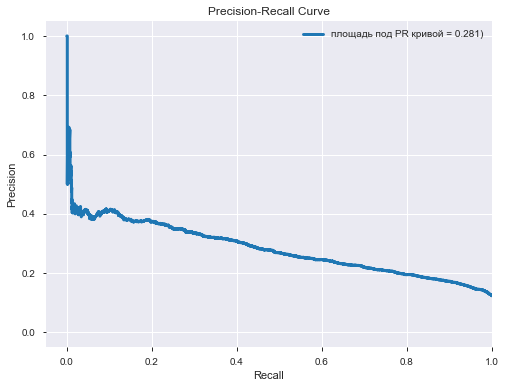

In [52]:
plt.figure(figsize=(8, 6))
prc_area = auc(recall, precision)
plt.plot(recall, precision, lw=3, label='площадь под PR кривой = %0.3f)' % prc_area)
    
plt.xlim([-.05, 1.0])
plt.ylim([-.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

In [53]:
add_metrics = pd.DataFrame({'Метрика': ['ROC_AUC', 'PRC_AUC'], 'Значение': [roc_auc, prc_area]}, columns=['Метрика', 'Значение'])

first_metrics_df = first_metrics_df.append(add_metrics, ignore_index=True)

In [54]:
print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
print('Precision: %.4f' % precision_score(y_valid, y_pred))
print('Recall: %.4f' % recall_score(y_valid, y_pred))
print('F1: %.4f' % f1_score(y_valid, y_pred))

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
print('PRC_AUC = ', round(auc(recall, precision), 4))

Accuracy: 0.8751
Precision: 0.4149
Recall: 0.0213
F1: 0.0406
ROC_AUC =  0.7403
PRC_AUC =  0.2809


In [55]:
model = LogisticRegression(random_state=42)

iter_max = 300

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=300, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=42, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


In [56]:
# Обучим модель на данных и проверим confusion_matrix

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

In [57]:
# матрица ошибок
tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
print(tp, fp) 
print(fn, tn)

1247 4326
580 8607


In [58]:
print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
print('Precision: %.4f' % precision_score(y_valid, y_pred))
print('Recall: %.4f' % recall_score(y_valid, y_pred))
print('F1: %.4f' % f1_score(y_valid, y_pred))

precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
print('PRC_AUC = ', round(auc(recall, precision), 4))

Accuracy: 0.6676
Precision: 0.2238
Recall: 0.6825
F1: 0.3370
ROC_AUC =  0.7399
PRC_AUC =  0.2801


Submission

In [59]:
train_data = train[train['sample'] == 1].drop(['sample'], axis=1)
test_data = train[train['sample'] == 0].drop(['sample'], axis=1)

In [60]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [61]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 31), (73799, 31), (73799, 30), (73799,), (36349, 30))

In [62]:
model = LogisticRegression(random_state=42)

iter_max = 1000

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_max]},
]

gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
print(model)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [63]:
y_pred = model.predict_proba(X_test)[:,1]

In [64]:
submit = pd.DataFrame(data_test.client_id)
submit['default']=y_pred
submit.to_csv('submission.csv', index=False)
display(submit.head(10))

,client_id,default
0,74835,0.211510
1,17527,0.772803
2,75683,0.333981
3,26883,0.390526
4,28862,0.140068
5,99881,0.649220
6,26630,0.758716
7,79934,0.171793
8,16605,0.134891
9,105449,0.198178
